In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install csaps

In [37]:
import os
import pandas as pd
import numpy as np
from csaps import csaps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [38]:
  def pre(ind):
    if ind < 10:
        files = os.listdir(f"/content/drive/My Drive/ResearchProject/PC_BigIdeas/00{ind}/glucose_activity")
    if ind > 9:
        files = os.listdir(f"/content/drive/My Drive/ResearchProject/PC_BigIdeas/0{ind}/glucose_activity")

    if not files:
        print(f"Skipping {ind}: No bouts found.")
        return np.array([]), np.array([]), np.array([])
    df_list = []
    A = []
    T = np.arange(0, 65, 5)
    glucose = []

    for bout in files:
        if ind < 10:
            df = pd.read_csv(f"/content/drive/My Drive/ResearchProject/PC_BigIdeas/00{ind}/glucose_activity/{bout}")
        if ind > 9:
            df = pd.read_csv(f"/content/drive/My Drive/ResearchProject/PC_BigIdeas/0{ind}/glucose_activity/{bout}")

        df = df.tail(13) # We only select the one hour period after activity has ended

        if len(df) < 13:
            continue

        df.reset_index(drop=True, inplace=True)
        random_perturbation = np.random.normal(0, 0.01)
        df['period_duration (mins)'] = df['period_duration (mins)'] + random_perturbation

        if df['period_duration (mins)'].iloc[0] > 180:
            continue

        A.append(df['period_duration (mins)'].iloc[0])
        df['d_glucose'] = df['glucose'] - df['glucose'].iloc[0]
        df_list.append(df)
        glucose.append(list(df['d_glucose']))

    sorted_dflist = sorted(df_list, key=lambda x: x['period_duration (mins)'].iloc[0])
    df_list = sorted_dflist

    A = sorted(A)
    glucose = np.array(glucose)
    T = np.array(T)
    A = np.array(A)

    return glucose, A, T

In [39]:
def variation_magnitude(ind, dur):
    glucose, A, T = pre(ind)

    if glucose.size == 0 or A.size == 0 or T.size == 0:
        print(f"Individual {ind} has no activity bouts.")
        return None
    if A.size == 1:
        print(f"Individual {ind} has only 1 activity bout.")
        return None

    xdata = [A, T]
    ydata = np.array(glucose)
    i, j = np.meshgrid(A, T)
    X_domain = np.linspace(A.min(), A.max(), 2000)
    Y_domain = np.linspace(T.min(), T.max(), 2000)
    domain = [X_domain, Y_domain]
    model = csaps(xdata, ydata, smooth = 0.2)
    y_data_s = model(domain)
    variance = np.var(y_data_s, axis=1)

    plt.plot(X_domain, np.var(y_data_s, axis=1))
    plt.title(f'Individual {ind}')
    plt.xlabel('Duration (min)')
    plt.ylabel(r'$\sigma_p^2$')
    plt.show()


    idx = (np.abs(X_domain - dur)).argmin()
    fluctuation = variance[idx]

    print(f"Individual {ind}: Estimated glucose fluctuation after {dur} minutes of exercise: {fluctuation:.4f}")


In [34]:
for ind in range(1, 17):
    variation_magnitude(ind)

TypeError: variation_magnitude() missing 1 required positional argument: 'dur'

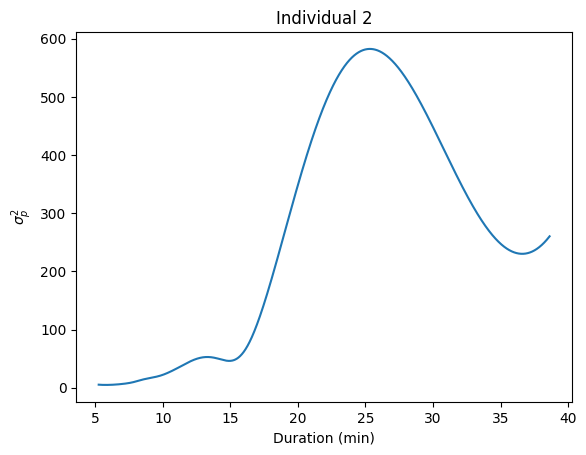

Individual 2: Estimated glucose fluctuation after 20 minutes of exercise: 348.2360


In [43]:
variation_magnitude(2, 20)